# Исследование модели NODE.

## Импорты

In [2]:
import copy
import random
import warnings

import numpy as np
import pandas as pd
import scipy.stats as sps

from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim

warnings.simplefilter("ignore", DeprecationWarning)
sns.set(context='poster')
%matplotlib inline

np.random.seed(42)

## Данные

In [63]:
train_Mortgage = pd.read_csv('train_Mortgage.csv')
val_Mortgage = pd.read_csv('val_Mortgage.csv')

train_Pension = pd.read_csv('train_Pension.csv')
val_Pension = pd.read_csv('val_Pension.csv')

train_Savings = pd.read_csv('train_Savings.csv')
val_Savings = pd.read_csv('val_Savings.csv')

In [64]:
test = pd.read_csv('unknown_behaviors.csv')
test.head()

,customer_id,age,age_youngest_child,debt_equity,gender,bad_payment,gold_card,pension_plan,household_debt_to_equity_ratio,income,members_in_household,months_current_account,months_customer,call_center_contacts,loan_accounts,number_products,number_transactions,non_worker_percentage,white_collar_percentage,rfm_score
0,44256,38,11,38,1,0,0,0,58,47958.0,4,41,48,2,1,2,1,9,31,7.949
1,46883,30,1,30,0,0,0,0,55,48606.0,2,23,36,2,4,3,2,11,33,11.437
2,32387,41,13,41,1,0,0,0,59,42152.0,4,39,48,1,0,1,1,11,29,7.462
3,25504,42,14,42,1,0,0,0,57,39788.0,3,21,24,2,3,0,0,15,27,0.000
4,35979,42,14,42,1,0,0,0,53,44365.0,6,41,48,3,2,3,1,5,41,7.806


In [65]:
test = test.drop(['customer_id'], axis=1)
feature_columns = test.columns

X_train_Mortgage = train_Mortgage[feature_columns]
y_train_Mortgage = train_Mortgage[['Mortgage']]

X_val_Mortgage = val_Mortgage[feature_columns]
y_val_Mortgage = val_Mortgage[['Mortgage']]

X_train_Pension = train_Pension[feature_columns]
y_train_Pension = train_Pension[['Pension']]

X_val_Pension = val_Pension[feature_columns]
y_val_Pension = val_Pension[['Pension']]

X_train_Savings = train_Savings[feature_columns]
y_train_Savings = train_Savings[['Savings']]

X_val_Savings = val_Savings[feature_columns]
y_val_Savings = val_Savings[['Savings']]

#### Обработка данных

Для этой модели необходимо обработать данные. Сделаем это для признака `Mortgage`.

In [66]:
scaler = StandardScaler()
X_train_Mortgage = scaler.fit_transform(X_train_Mortgage)
X_val_Mortgage = scaler.transform(X_val_Mortgage)

le = LabelEncoder()
y_train_Mortgage = le.fit_transform(y_train_Mortgage)
y_val_Mortgage = le.fit_transform(y_val_Mortgage)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Теперь для признака `Pension`.

In [67]:
scaler = StandardScaler()
X_train_Pension = scaler.fit_transform(X_train_Pension)
X_val_Pension = scaler.transform(X_val_Pension)

le = LabelEncoder()
y_train_Pension = le.fit_transform(y_train_Pension)
y_val_Pension = le.fit_transform(y_val_Pension)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


И для признака `Savings`.

In [68]:
scaler = StandardScaler()
X_train_Savings = scaler.fit_transform(X_train_Savings)
X_val_Savings = scaler.transform(X_val_Savings)

le = LabelEncoder()
y_train_Savings = le.fit_transform(y_train_Savings)
y_val_Savings = le.fit_transform(y_val_Savings)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Затем переведем данные в формат `pytorch tensor`. Признак `Mortgage`.

In [69]:
X_train_Mortgage = torch.tensor(X_train_Mortgage, dtype=torch.float32)
X_val_Mortgage = torch.tensor(X_val_Mortgage, dtype=torch.float32)
y_train_Mortgage = torch.tensor(y_train_Mortgage, dtype=torch.long)
y_val_Mortgage = torch.tensor(y_val_Mortgage, dtype=torch.long)

Теперь признак `Pension`.

In [70]:
X_train_Pension = torch.tensor(X_train_Pension, dtype=torch.float32)
X_val_Pension = torch.tensor(X_val_Pension, dtype=torch.float32)
y_train_Pension = torch.tensor(y_train_Pension, dtype=torch.long)
y_val_Pension = torch.tensor(y_val_Pension, dtype=torch.long)

И признак `Savings`.

In [71]:
X_train_Savings = torch.tensor(X_train_Savings, dtype=torch.float32)
X_val_Savings = torch.tensor(X_val_Savings, dtype=torch.float32)
y_train_Savings = torch.tensor(y_train_Savings, dtype=torch.long)
y_val_Savings = torch.tensor(y_val_Savings, dtype=torch.long)

Теперь реализуем модель `NODE` через `pytorch-модули`.

In [72]:
class ResBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )

    def forward(self, x):
        return x + self.net(x)

class ODEFunc(nn.Module):
    def __init__(self, hidden_dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            ResBlock(hidden_dim),
            ResBlock(hidden_dim),
        )
    def forward(self, x):
        return self.net(x)


class NODEClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NODEClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.ode_func = ODEFunc(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # out = odeint(self.ode_func, x, torch.linspace(0, 1, 2), method='dopri5')[-1]
        out = torch.relu(self.ode_func(x))
        out = self.fc2(out)
        return out

Напишем функцию для отрисовки истории обучения.

In [84]:
def plot_training_results(results, task_name):
    """
    Визуализирует результаты обучения (loss и accuracy).

    Args:
        results (dict): Словарь с результатами обучения.
        task_name (str): Название задачи (например, "Mortgage").
    """
    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(results["loss_history"])
    plt.title(f"{task_name} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(results["roc_auc_history"], label="Train")
    plt.plot(results["val_roc_auc_history"], label="Validation")
    plt.title(f"{task_name} - ROC-AUC")
    plt.xlabel("Epoch")
    plt.ylabel("ROC-AUC")
    plt.legend()

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

И для отрисовки `ROC-AUC` кривой.

In [ ]:
def plot_roc_auc(results, y_true, task_name):
    """
    Строит график ROC-AUC.

    Args:
        results (dict): Результаты обучения (должны содержать "val_probabilities").
        y_true (numpy.ndarray): Истинные метки классов (для валидационной выборки).
        task_name (str): Название задачи.
    """
    y_pred_proba = results["val_probabilities"] #Вероятности принадлежности к классам
    if y_pred_proba.shape[1] == 2: #Двоичная классификация
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba[:, 1])  # Для бинарной классификации
        auc_score = roc_auc_score(y_true, y_pred_proba[:, 1])
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.2f})")
    else: #Многоклассовая классификация
        from sklearn.preprocessing import label_binarize
        y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
        auc_scores = []
        for i in range(y_pred_proba.shape[1]): #Проходим по каждому классу
            fpr, tpr, thresholds = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
            auc_score = roc_auc_score(y_true_bin[:, i], y_pred_proba[:, i])
            auc_scores.append(auc_score)
            plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')  # Случайный классификатор
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{task_name} - ROC Curve')
    plt.legend()
    plt.show()

Обучим модель для признака `Mortgage`.

In [91]:
input_dim = X_train_Mortgage.shape[1]
hidden_dim = 64
output_dim = len(torch.unique(y_train_Mortgage))
model = NODEClassifier(input_dim, hidden_dim, output_dim)

#Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

#Train loop
num_epochs = 500


loss_history = []
roc_auc_history = []
val_roc_auc_history = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_Mortgage)
    loss = criterion(outputs, y_train_Mortgage)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        loss_history.append(loss.item())

    model.eval()
    with torch.no_grad():

        train_outputs = model(X_train_Mortgage)
        y_pred = torch.argmax(model(X_val_Mortgage), dim=1)
        roc_auc = roc_auc_score(y_val_Mortgage, y_pred)
        if (epoch+1) % 10 == 0:
            roc_auc_history.append(roc_auc)

        val_outputs = model(X_val_Mortgage)
        val_probs = torch.softmax(val_outputs, dim=1)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_roc_auc = roc_auc_score(y_val_Mortgage.cpu(), val_preds.cpu())
        if (epoch+1) % 10 == 0:

            val_roc_auc_history.append(val_roc_auc)
        if (epoch+1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Train ROC-AUC: {roc_auc:.4f}, Val ROC-AUC: {val_roc_auc:.4f}")

results_mortgage = {
        "loss_history": loss_history,
        "roc_auc_history": roc_auc_history,
        "val_roc_auc_history": val_roc_auc_history,
        "val_probabilities": val_probs.cpu().numpy(),
    }

Epoch 50/500, Loss: 0.1785, Train ROC-AUC: 0.7973, Val ROC-AUC: 0.7973
Epoch 100/500, Loss: 0.1537, Train ROC-AUC: 0.8198, Val ROC-AUC: 0.8198
Epoch 150/500, Loss: 0.1304, Train ROC-AUC: 0.7988, Val ROC-AUC: 0.7988
Epoch 200/500, Loss: 0.1022, Train ROC-AUC: 0.7943, Val ROC-AUC: 0.7943
Epoch 250/500, Loss: 0.0689, Train ROC-AUC: 0.7913, Val ROC-AUC: 0.7913
Epoch 300/500, Loss: 0.1455, Train ROC-AUC: 0.8138, Val ROC-AUC: 0.8138
Epoch 350/500, Loss: 0.0891, Train ROC-AUC: 0.7883, Val ROC-AUC: 0.7883
Epoch 400/500, Loss: 0.0583, Train ROC-AUC: 0.7883, Val ROC-AUC: 0.7883
Epoch 450/500, Loss: 0.0455, Train ROC-AUC: 0.7628, Val ROC-AUC: 0.7628
Epoch 500/500, Loss: 0.0400, Train ROC-AUC: 0.7538, Val ROC-AUC: 0.7538


Посмотрим на историю обучения.

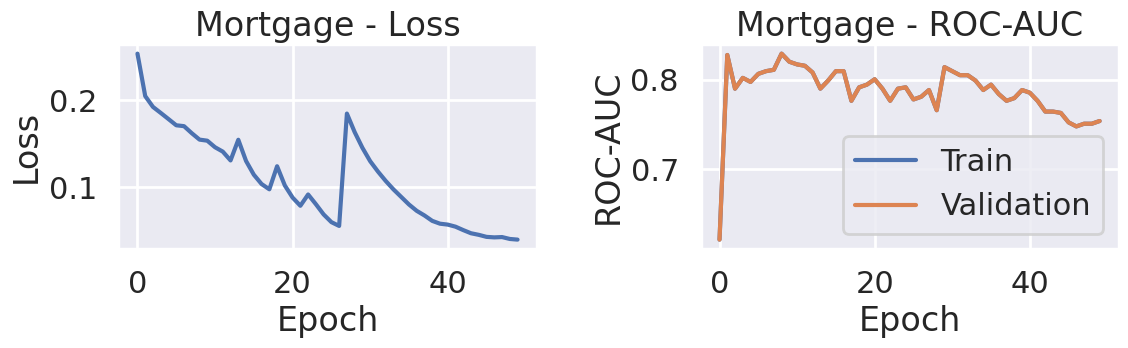

In [92]:
plot_training_results(results_mortgage, "Mortgage")

И на график `ROC-AUC`.

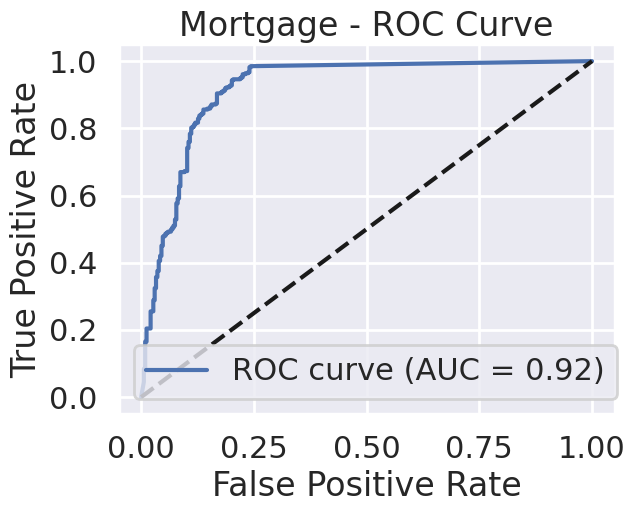

In [95]:
plot_roc_auc(results_mortgage, y_val_Mortgage.cpu().numpy(), "Mortgage")

Обучим модель для признака `Pension`.

In [96]:
input_dim = X_train_Pension.shape[1]
hidden_dim = 64
output_dim = len(torch.unique(y_train_Pension))
model = NODEClassifier(input_dim, hidden_dim, output_dim)

#Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

#Train loop
num_epochs = 500


loss_history = []
roc_auc_history = []
val_roc_auc_history = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_Pension)
    loss = criterion(outputs, y_train_Pension)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        loss_history.append(loss.item())

    model.eval()
    with torch.no_grad():

        train_outputs = model(X_train_Pension)
        y_pred = torch.argmax(model(X_val_Pension), dim=1)
        roc_auc = roc_auc_score(y_val_Pension, y_pred)
        if (epoch+1) % 10 == 0:
            roc_auc_history.append(roc_auc)

        val_outputs = model(X_val_Pension)
        val_probs = torch.softmax(val_outputs, dim=1)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_roc_auc = roc_auc_score(y_val_Pension.cpu(), val_preds.cpu())
        if (epoch+1) % 10 == 0:
            val_roc_auc_history.append(val_roc_auc)
        if (epoch+1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Train ROC-AUC: {roc_auc:.4f}, Val ROC-AUC: {val_roc_auc:.4f}")
results_pension = {
        "loss_history": loss_history,
        "roc_auc_history": roc_auc_history,
        "val_roc_auc_history": val_roc_auc_history,
        "val_probabilities": val_probs.cpu().numpy(),
    }

Epoch 50/500, Loss: 0.4139, Train ROC-AUC: 0.5570, Val ROC-AUC: 0.5570
Epoch 100/500, Loss: 0.3624, Train ROC-AUC: 0.6548, Val ROC-AUC: 0.6548
Epoch 150/500, Loss: 0.2898, Train ROC-AUC: 0.5784, Val ROC-AUC: 0.5784
Epoch 200/500, Loss: 0.2142, Train ROC-AUC: 0.5825, Val ROC-AUC: 0.5825
Epoch 250/500, Loss: 0.1591, Train ROC-AUC: 0.5947, Val ROC-AUC: 0.5947
Epoch 300/500, Loss: 0.1488, Train ROC-AUC: 0.5886, Val ROC-AUC: 0.5886
Epoch 350/500, Loss: 0.1058, Train ROC-AUC: 0.5896, Val ROC-AUC: 0.5896
Epoch 400/500, Loss: 0.1135, Train ROC-AUC: 0.5886, Val ROC-AUC: 0.5886
Epoch 450/500, Loss: 0.0857, Train ROC-AUC: 0.5794, Val ROC-AUC: 0.5794
Epoch 500/500, Loss: 0.0855, Train ROC-AUC: 0.5774, Val ROC-AUC: 0.5774


Визуализируем историю обучения.

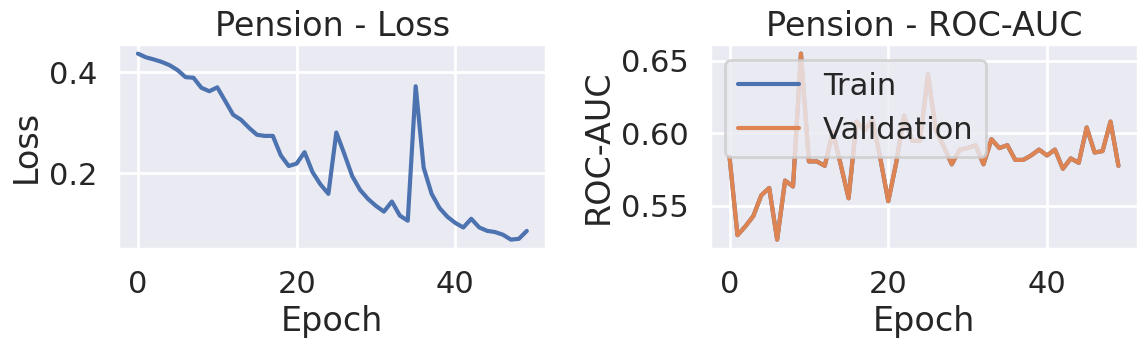

In [97]:
plot_training_results(results_pension, "Pension")

Строим график `ROC-AUC`.

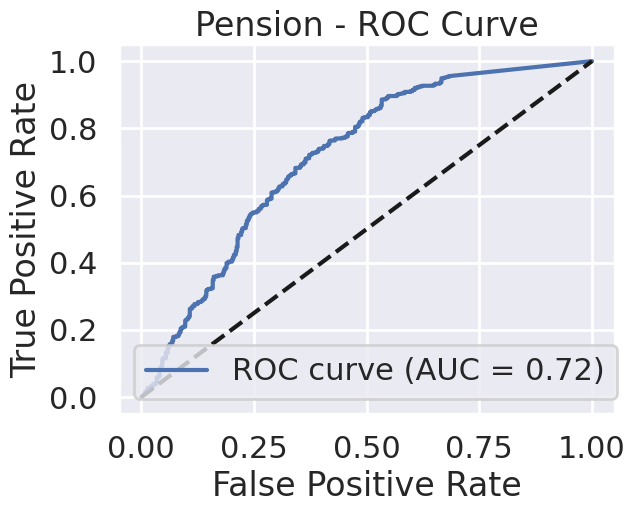

In [98]:
plot_roc_auc(results_pension, y_val_Pension.cpu().numpy(), "Pension")

Теперь обучим для признака `Savings`.

In [99]:
input_dim = X_train_Savings.shape[1]
hidden_dim = 64
output_dim = len(torch.unique(y_train_Savings))
model = NODEClassifier(input_dim, hidden_dim, output_dim)

#Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

#Train loop
num_epochs = 500


loss_history = []
roc_auc_history = []
val_roc_auc_history = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_Savings)
    loss = criterion(outputs, y_train_Savings)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        loss_history.append(loss.item())

    model.eval()
    with torch.no_grad():

        train_outputs = model(X_train_Savings)
        y_pred = torch.argmax(model(X_val_Savings), dim=1)
        roc_auc = roc_auc_score(y_val_Savings, y_pred)
        if (epoch+1) % 10 == 0:
            roc_auc_history.append(roc_auc)

        val_outputs = model(X_val_Savings)
        val_probs = torch.softmax(val_outputs, dim=1)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_roc_auc = roc_auc_score(y_val_Savings.cpu(), val_preds.cpu())
        if (epoch+1) % 10 == 0:
            val_roc_auc_history.append(val_roc_auc)
        if (epoch+1) % 50 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Train ROC-AUC: {roc_auc:.4f}, Val ROC-AUC: {val_roc_auc:.4f}")
results_savings = {
        "loss_history": loss_history,
        "roc_auc_history": roc_auc_history,
        "val_roc_auc_history": val_roc_auc_history,
        "val_probabilities": val_probs.cpu().numpy(),
    }

Epoch 50/500, Loss: 0.5815, Train ROC-AUC: 0.5775, Val ROC-AUC: 0.5775
Epoch 100/500, Loss: 0.5519, Train ROC-AUC: 0.5379, Val ROC-AUC: 0.5379
Epoch 150/500, Loss: 0.4788, Train ROC-AUC: 0.5669, Val ROC-AUC: 0.5669
Epoch 200/500, Loss: 0.3227, Train ROC-AUC: 0.5473, Val ROC-AUC: 0.5473
Epoch 250/500, Loss: 0.3230, Train ROC-AUC: 0.5550, Val ROC-AUC: 0.5550
Epoch 300/500, Loss: 0.1795, Train ROC-AUC: 0.5497, Val ROC-AUC: 0.5497
Epoch 350/500, Loss: 0.1482, Train ROC-AUC: 0.5467, Val ROC-AUC: 0.5467
Epoch 400/500, Loss: 0.2293, Train ROC-AUC: 0.5515, Val ROC-AUC: 0.5515
Epoch 450/500, Loss: 0.1264, Train ROC-AUC: 0.5438, Val ROC-AUC: 0.5438
Epoch 500/500, Loss: 0.1008, Train ROC-AUC: 0.5485, Val ROC-AUC: 0.5485


История обучения.

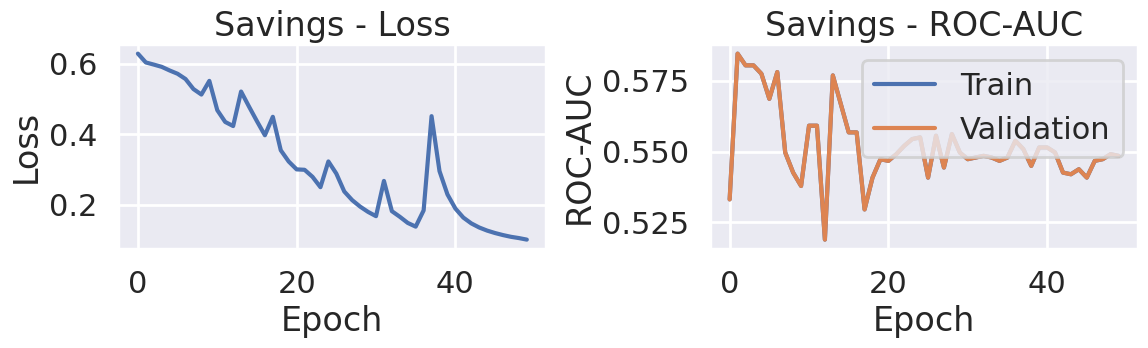

In [100]:
plot_training_results(results_savings, "Savings")

Кривая `ROC-AUC`.

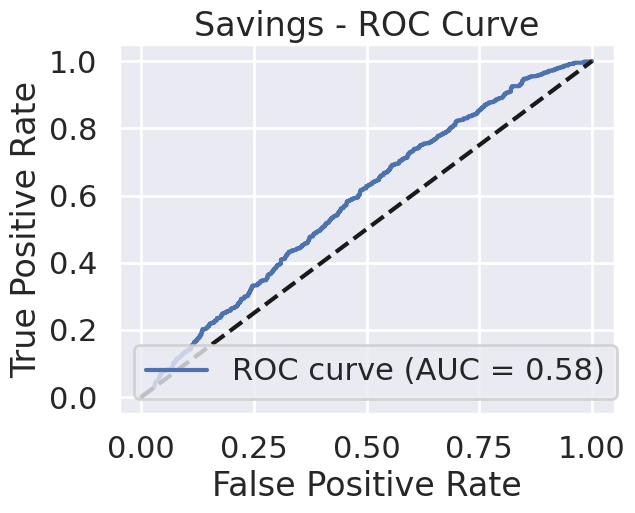

In [101]:
plot_roc_auc(results_savings, y_val_Savings.cpu().numpy(), "Savings")

Видим, что модель в своей базовой версии сильно уступает модели `ExtraTrees` по всем таргетам, так что возможно стоит попробовать добавить дополнитальные детали в архитектуру для улучшения метрик.